<div class="alert alert-block alert-info">
<h3>Airplane Data Methodology</h3> 
<b>Name</b>: Alec Cotler<br> 

<h3>Data Extraction</h3> 

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def encode_class(x):
    if x.lower() == "business":
        return 0
    elif x.lower() =="eco":
        return 1
    elif x.lower() ==  "eco Plus":
        return 2
    else:
        return np.nan
    
def encode_gender(x):
    if x.lower() == "female":
        return 0
    elif x.lower() =="male":
        return 1
    else:
        return np.nan
    

def encode_customer_type(x):
    if x.lower() == "disloyal customer":
        return 0
    elif x.lower() =="loyal customer":
        return 1
    else:
        return np.nan
   
def encode_type_of_travel(x):
    if x.lower() == "business travel":
        return 0
    elif x.lower() =="personal travel":
        return 1
    else:
        return np.nan
def encode_satisfaction(x):
    if x.lower() == "neutral or dissatisfied":
        return 0
    elif x.lower() =="satisfied":
        return 1
    else:
        return np.nan



def transform_categorical_data(df):
    df = df.assign(
    Class=df["Class"].apply(encode_class),
    Gender=df["Gender"].apply(encode_gender),
    **{"Customer Type": df["Customer Type"].apply(encode_customer_type)},
    **{"Type of Travel": df["Type of Travel"].apply(encode_type_of_travel)},
    satisfaction=df["satisfaction"].apply(encode_satisfaction))

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True) 

    features = df.iloc[:, 2:24]
    labels= df["satisfaction"]

    scaler = StandardScaler()
    features[["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]] = scaler.fit_transform(features[["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]])

    return features, labels

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_features, y_train = transform_categorical_data(train_df)
test_features, y_test = transform_categorical_data(test_df)

<h3>K-Means Clustering</h3> 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_k_means_clustering(features_2d, cluster_labels, centers_2d, graph_version):
    plt.figure(figsize=(8, 6))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.6)
    plt.scatter(
        centers_2d[:, 0], centers_2d[:, 1],
        c='black', s=150, marker='X', label='Centers'
    )
    plt.title(f"KMeans Clustering ({graph_version})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

training_features_arr = train_features.to_numpy() # training_features is originally a dataframe

# # # # # # # # # # # # #
# sklearn implementation #
# # # # # # # # # # # # #
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(training_features_arr) 

# Visualization (use PCA)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(training_features_arr)

centers_2d = pca.transform(kmeans.cluster_centers_) # adjust cluster to 2D using PCA


plot_k_means_clustering(features_2d, cluster_labels, centers_2d, "sklearn")

# # # # # # # # # # # # # # # #
# Our Function implementation #  
# # # # # # # # # # # # # # # #

def kmeans(X, k, max_iter=10):
    Mu = X[np.random.choice(X.shape[0], k), :] 
    losses = []    

    for i in range(max_iter):
        D = -2 * X @ Mu.T + (X**2).sum(axis=1)[:, None] + (Mu**2).sum(axis=1)
        assignments = np.argmin(D, axis=1)
        C = np.eye(k)[assignments, :]
        Mu = (C.T @ X) / np.sum(C, axis=0)[:, None]

        loss = np.linalg.norm(X - Mu[assignments, :])**2
        losses.append(loss)

    return Mu, assignments, losses

  
Mu, cluster_labels, losses = kmeans(training_features_arr, k=2, max_iter=20)

# Show convergence of loss
plt.plot(losses, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('K-Means Convergence (Our Function)')
plt.grid()
plt.show()


# Apply PCA to 2D
pca = PCA(n_components=2)
features_2d = pca.fit_transform(training_features_arr)
centers_2d = pca.transform(Mu)
plot_k_means_clustering(features_2d, cluster_labels, centers_2d, "Our Function")

<h3>Principal Component Analysis (PCA)</h3> 

In [ ]:
from sklearn.decomposition import PCA
import re

pca = PCA(n_components=2)
features_2d = pca.fit_transform(train_features)

# PCA top features
loadings = pca.components_ 
for i in range(2):
    print(f"\nTop features for Principal Component {i+1}:")
    component = loadings[i]
    indices = np.argsort(np.abs(component))[::-1]
    for idx in indices:
        print(f"{train_features.columns[idx]}: {component[idx]:.4f}")

# Plotting 
label_names = {0: "neutral or dissatisfied", 1: "satisfied"}


plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_train, cmap='tab10', alpha=0.7)
handles, raw_labels = scatter.legend_elements()
clean_labels = [int(re.sub(r"[^\d]", "", lbl)) for lbl in raw_labels]
word_labels = [label_names[i] for i in clean_labels]
plt.legend(handles,
    word_labels,
    title="Classes",
    loc="upper right"), 
plt.title("PCA of Features (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

<h3>Multilayer Perceptron (MLP)</h3> 
<div>Note that this takes a very long time to run</div>

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_recall_curve,precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define hyperparameter grid
param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.0, 0.0001, 0.001],  # None (0), L2 reg
    'learning_rate_init': [0.001, 0.01, 0.1],  # constant rates
    'learning_rate': ['constant'],  # fixed mode
    'max_iter': [500],
    'random_state': [42],
    'hidden_layer_sizes':[(50,), (100,), (100, 50)]
}

# Set up grid search
grid_search = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)


# Train
grid_search.fit(train_features, y_train)
best_model = grid_search.best_estimator_


# Predict and choose optimal threshold
probs = best_model.predict_proba(test_features)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test.to_numpy(), probs)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
y_pred = (probs >= best_threshold).astype(int)



tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


# Results
print("\nBest Parameters:", grid_search.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Best F1 Score: {f1s[best_idx]:.4f}")
print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"False Positive Rate: {fpr:.4f}")
print(f"False Negative Rate: {fnr:.4f}")

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("MLP Confusion Matrix (Tuned)")
plt.tight_layout()
plt.show()


# Plot loss curve for best model
plt.figure()
plt.plot(best_model.loss_curve_)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve of Best MLP Model (Tuned)")
plt.grid(True)
plt.tight_layout()
plt.show()

<h3>K Nearest Neighbors (KNN)</h3> 

k: 1, mean score: 0.9169839785390315
k: 5, mean score: 0.9293219436131475
k: 10, mean score: 0.9272309325378494
k: 20, mean score: 0.9259305537838403
k: 50, mean score: 0.921041137265761
k: 100, mean score: 0.914861759724214
Accuracy: 0.9320712230515825
Recall: 0.9019373794876504
Precision: 0.9459745762711864
F1 Score: 0.9234312573443009
False Positive Rate: 0.04285714285714286
False Negative Rate: 0.09806262051234965


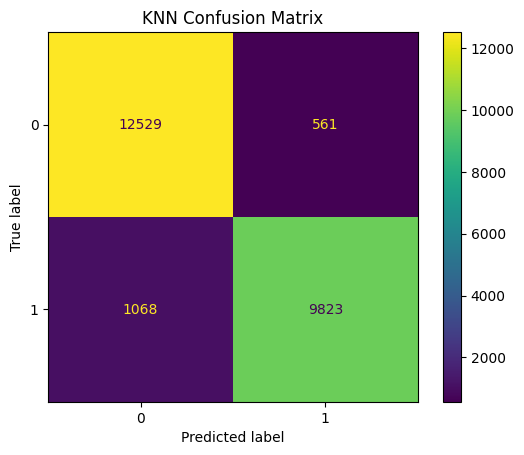

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, precision_recall_curve, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import ConfusionMatrixDisplay

k_values = [1,5,10,20,50,100]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, train_features, y_train, cv=5)
    mean_score = np.mean(score)
    print(f"k: {k}, mean score: {mean_score}")
    scores.append(mean_score)


best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(train_features, y_train)
y_pred = knn.predict(test_features)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_mat.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("False Positive Rate:", fpr)
print("False Negative Rate:", fnr)

# Plot K value selection 
# plt.plot(scores, marker='o')
# plt.xlabel('K value')
# plt.ylabel('Accuracy')
# plt.title('K-value vs Accuracy')
# plt.grid()
# plt.show()


ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("KNN Confusion Matrix")
plt.show()

<h3>Random Forest</h3> 
<div>Note that this takes a very long time to run</div>

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, precision_recall_curve, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_features, y_train)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(test_features)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_mat.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("Optimal hyperparameters:", grid_search.best_params_)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("False Positive Rate:", fpr)
print("False Negative Rate:", fnr)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Random Forest Confusion Matrix")
plt.show()


#Plot Tree
estimator = best_rf.estimators_[0]  
plt.figure(figsize=(20, 10))
plot_tree(estimator, 
          feature_names=train_features.columns,  
          class_names=[str(cls) for cls in best_rf.classes_], 
          filled=True, 
          rounded=True,
          max_depth=2)  # limit depth for clarity
plt.show()